<img src="e4e_banner2.gif" />
# Engineers for Exploration - RCT Signal Analysis
## Jupyter Notebook Demonstration

***
Created by **Anthony Koutroulis** with source material derived from the
__[E4E Radio Collar Tracker Project](https://github.com/UCSD-E4E/radio_collar_tracker)__
maintained by **Nathan Hui** <br>

*Made possible by the National Science Foundation's REU program and UCSD's Engineers For Exploration, 2017*
***

This 

### Dependencies
Run the following cell before beginning analysis to import the required libraries. <br>
To run this, and any other cell, click on the text area of the cell and press __Shift+Enter__ on your keyboard.

In [13]:
# Available from the Anaconda Scientific Computing Distribution
import ipywidgets as widgets
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.signal as sg
import seaborn as sns
import peakutils as pu

# Libraries custom made for signal analysis of the RCT Project
import src.widgets as rctw # custom widgets
import src.rct as rct      # signal processing functions

# Set default graph configurations/style
sns.set()
%matplotlib notebook
mpl.rcParams['figure.figsize'] = [9.5, 6.0]

# Set system defaults
FFT_LENGTH = 4096

### File Selection
Run the next cell (by clicking on the text area and pressing **Shift+Enter**) to launch a file selection widget. <br>
Once the widget has appeared, simply enter the relative or absolute path pointing to the location of the recorded SDR data. You then may adjust the series, run number, and range of files to perform analysis on. <br>
*Alternatively, adjust the ``default`` variables in the code block*

In [18]:
# Hard coded defaults
default_path = '../../Desktop/E4E/rct_runs/'
default_series = 'desert'
default_run = '16'
default_range = (1,3)
defaults = [default_path, default_series, default_run, default_range]

# Creates and Displays the file selection widget
file_wdgt = rctw.FileWidget(defaults)
file_wdgt.display()

A Jupyter Widget

### Run Variables
Run the next cell to launch a widget that allows you to enter the runtime variables, these include:
* Sampling frequency of the SDR     (`sampling_freq`)
* Center frequency of the SDR       (`center_freq`)
* Number of collars to be processed (`num_collars`)
* Collar frequency for each collar  (`collar_freq`)


In [3]:
##TODO: Add input widget and support for multiple collars

# SDR settings
sampling_freq = 2000000.0
center_freq = 172500000.0

# Collar characteristics
collar_freq = 172950830.0
pW = 0.02
pT = 1.60

### Prepare Raw Data Files for Analysis
Run the next cell to fetch the raw data and prepare it for analysis.<br>
*This process can take a long time for multiple files, wait for the progress bar to turn green before continuing.*<br>
***
Once completed, a graph of the signal power over time will display. The pulse characteristics are recalculated based on downsampled data. With more precise characteristics, predictions can be made to the locallity of each pulse.

A Jupyter Widget

<IPython.core.display.Javascript object>


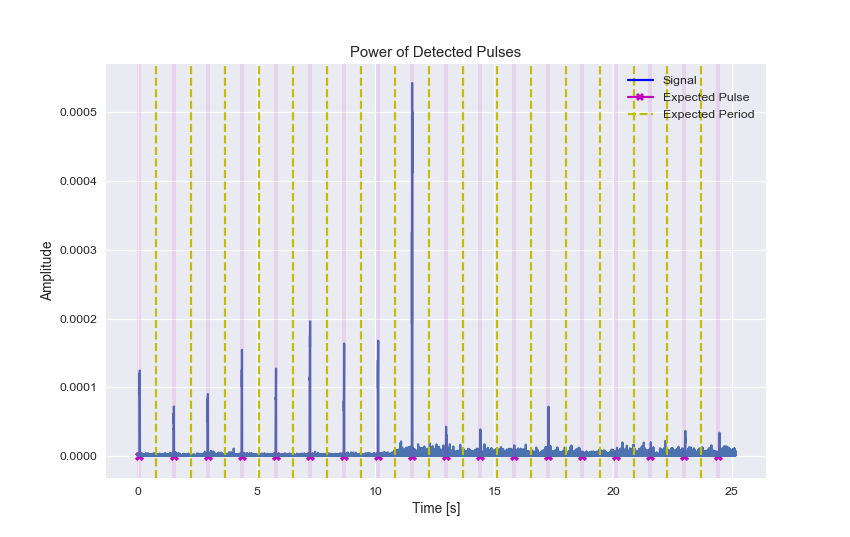

In [15]:
# Set variables used in DFFT
Fx        = sampling_freq / FFT_LENGTH # sampling frequency
dt        = 1/Fx
freq_bin  = int( np.round( (collar_freq - center_freq) / sampling_freq * FFT_LENGTH))

# Get files
raw_files = file_wdgt.getFiles()

# Create power spectrum from files
Px        = rct.fftFromFiles(rctw.log_progress(raw_files, every=1, name='Processing File'), 
                             FFT_LENGTH, freq_bin, sampling_freq, w='boxcar')
t         = np.linspace(dt,len(Px)*dt,len(Px))

# Correct pulse characteristics
pT        = rct.findTruePeriod(Px,pW,pT,Fx)
pW        = rct.findTrueWidth(Px,pW,pT,Fx)
pmax      = np.argmax(Px)
pulses    = rct.predictPulses(t,Fx,pT,pmax)
periods   = rct.predictPeriods(t,Fx,pT,pmax)

# Plot processed data with predictions
pow_fig   = plt.figure()
pow_plot  = plt.plot(t,Px) 
plt.show(pow_plot)
rct.plotPeriods(t,periods)
rct.plotPulses(t,pulses)

plt.title('Power of Detected Pulses')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

blu_lin = mlines.Line2D([],[],c='b')
mag_lin = mlines.Line2D([],[],c='m',marker='X')
yel_lin = mlines.Line2D([],[],c='y',linestyle='--')
plt.legend([blu_lin,mag_lin,yel_lin],
           ['Signal','Expected Pulse','Expected Period']);

### Filter and Detect
Running the next cell allow for interactive filtering of the power spectrum, with the goal of creating a clean destinction between signal and noise.<br>
A median filter is applied to smooth out the noise, this allows for peak detection with a reduced chance of detecting noise as a pulse.<br>
* Adjust the slider until the pulses are the most prominent feature on the graph, focusing on those close to the noise floor
* When done, click on the *Detect Peaks* button to display a scatter plot of the detected peaks
* Rerun the cell to start over (*TODO: fix this to remove this step*)

<IPython.core.display.Javascript object>


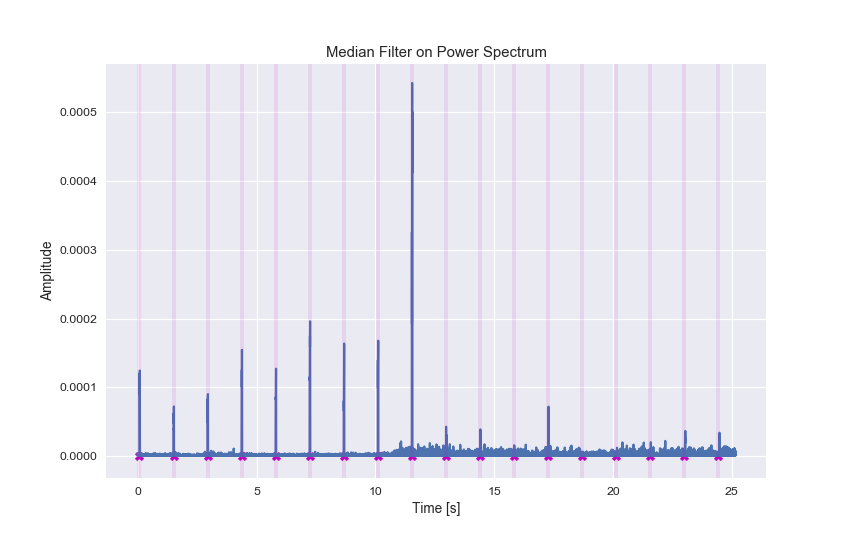

A Jupyter Widget

A Jupyter Widget

In [11]:
##TODO: add default (3 is good)
filt_wdgt = rctw.FilterWidget(t,Px)
filt_wdgt.display()
rct.plotPulses(t,pulses)

##TODO: wrap the following in a class, clear scatter on_click, return peaks   
def detect(b):
    Px_filt = filt_wdgt.getResult()
    peaks = pu.indexes(sg.convolve(Px_filt,sg.flattop(49),mode='same'), thres= 0, min_dist=(pT-pW)*Fx)  
    plt.scatter(t[peaks],Px_filt[peaks])

detect_wdgt = widgets.Button(
    description='Detect Pulses',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='runs peak detection',
    icon='check'
)

detect_wdgt.on_click(detect)
display(detect_wdgt)
plt.title('Median Filter on Power Spectrum')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

### Pulse Power and SNR
The pulses detected from the previous cell are collected into a variable ```pulse_pow```. The noise floor is also calculated and from that, the signal-to-noise ratio of each pulse is collected into a variable ```pulse_snr```<br>
These are plotted in a bar graph for quick inspection, but more importantly, they are available for use in the generation of a GPS heat map.

<IPython.core.display.Javascript object>


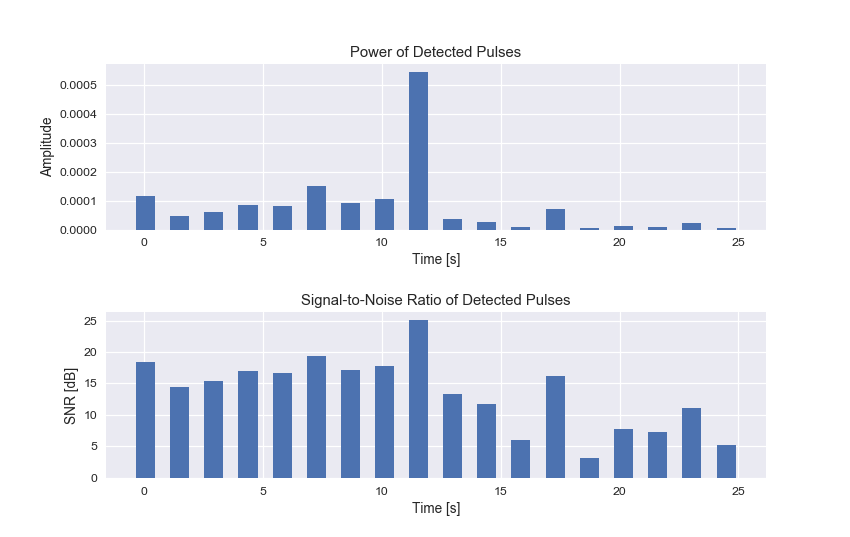

In [10]:
##TODO: change these to detect_wdgt.getPeaks() when implemented
Px_filt = filt_wdgt.getResult()
peaks = pu.indexes(sg.convolve(Px_filt,sg.flattop(49),mode='same'), thres= 0, min_dist=(pT-pW)*Fx)

pulse_pow = Px[peaks]
pulse_snr = rct.getSNR(Px,peaks,Fx,pW)

pow_plot = plt.figure()
plt.subplot(2,1,1)
plt.bar(t[peaks],pulse_pow)
plt.title('Power of Detected Pulses')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2,1,2)
plt.bar(t[peaks],pulse_snr)
plt.title('Signal-to-Noise Ratio of Detected Pulses')
plt.xlabel('Time [s]')
plt.ylabel('SNR [dB]')
plt.subplots_adjust(hspace=.5)